# Plotting for Review 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, vmap
from time import time

import math, os, sys
torch.manual_seed(0)

In [2]:
# dimension
D = 20

# domain width
L = 1.0

In [3]:
# rhs

om = 2.

c = -1.


def f(x):
    return (-om ** 2 + c) * (om * x).cos().sum()


# boundary condition
def g(x):
    return (om * x).cos().sum()


def u_true(x):
    return (om * x).cos().sum()

In [4]:
# path simulation time
T = 6. / np.sqrt(D)

# Total umber of paths
M_tot = 100000

# Batch size of each epoch
M = 1000

# number of grid points
N = 100

# number of grid points at the boundaries
N_bdry = 10000

# weight of boundary loss
c_boundary = 1.0

# number of collocation points for evaluating the integral
N_test = 10000

# number of training epochs
n_epoch = 5000

In [5]:
# time step size
dt = T / N
dBt = math.sqrt(dt)

def sample_NDstdBM_paths(M: int, D: int, T: float, N: int):
    return torch.cumsum(
        torch.concat([
            torch.concat([torch.ones(M, 1, 1), torch.zeros(M, 1, D - 1)], dim=2) * 0.1,
            torch.randn(M, N, D) * math.sqrt(T / N)
        ], dim=1), dim=1
    )


W_tot = sample_NDstdBM_paths(M_tot, D, T, N)

In [6]:
def mask_NDstdBM_paths(paths, L: float):
    oob = paths.abs().max(dim=2)[0].le(L).double()
    return oob.cummin(dim=1).values, oob.argmin(dim=1)


mask, exit_idx = mask_NDstdBM_paths(W_tot, L)
print(f"Boundary unreached rate: {mask[:, -1].sum().item() / M_tot * 100:.2f}%")

Boundary unreached rate: 0.00%


In [7]:
def sample_boundary_points(N_bdry: int, D: int, L: float):
    rand_u = torch.rand(N_bdry, D) - 0.5
    return rand_u / rand_u.abs().max(dim=1)[0].unsqueeze(dim=1) * L


X_bdry = sample_boundary_points(N_bdry, D, L)

In [8]:
u = nn.Sequential(nn.Linear(D, 64),
                  nn.Tanh(), # nn.GELU(approximate="tanh"),
                  nn.Linear(64, 32),
                  nn.GELU(approximate="tanh"),
                  nn.Linear(32, 1))

X_test = torch.rand(N_test, D) * 2 * L - L

optimizer = torch.optim.Adamax(u.parameters(), lr=.05, )

loss_rec = np.zeros(n_epoch + 1)
l2_err_rec = np.zeros(n_epoch + 1)
l2_norm_rec = np.zeros(n_epoch + 1)

f_val_tot = vmap(vmap(f))(W_tot)
g_val = vmap(g)(X_bdry)

In [9]:
# starting point
init1 = torch.zeros(D)
init1[0] = 0.1

# get u0 by Feynman-Kac formula
u0 = (vmap(g)(torch.stack([W_tot[i, exit_idx[i], :] for i in range(M_tot)])) * (c * exit_idx * dt / 2).exp() - .5 * \
     (f_val_tot * (torch.linspace(0, T, N+1) * c / 2).exp() * mask).sum(dim=1).mul(dt)).mean()
u0.item()

20.12824205076825

In [10]:
"""
x_test = torch.linspace(-L, L, 100).unsqueeze(dim=1) * torch.ones(D)
u_test = u(x_test)
u_test_true = vmap(u_true)(x_test)
plt.plot(np.linspace(-L, L, 100).unsqueeze(dim=1) * , u_test.detach().numpy().flatten())
plt.plot(np.linspace(-L, L, 100), u_test_true.detach().numpy().flatten())
plt.show()
"""

'\nx_test = torch.linspace(-L, L, 100).unsqueeze(dim=1) * torch.ones(D)\nu_test = u(x_test)\nu_test_true = vmap(u_true)(x_test)\nplt.plot(np.linspace(-L, L, 100).unsqueeze(dim=1) * , u_test.detach().numpy().flatten())\nplt.plot(np.linspace(-L, L, 100), u_test_true.detach().numpy().flatten())\nplt.show()\n'

# Plotting

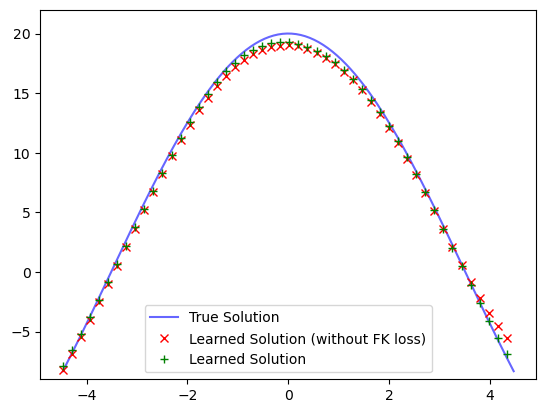

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, vmap
from time import time

import math, os, sys
torch.manual_seed(0)

u.load_state_dict(torch.load("the_network_07.pt"))


x_test = torch.linspace(-L, L, 200).unsqueeze(dim=1) * torch.ones(D)

plt.plot(np.linspace(-np.sqrt(D) * L, np.sqrt(D) * L, 200), vmap(u_true)(x_test).detach().numpy(), "b", alpha=0.6)

plt.plot(np.linspace(-np.sqrt(D) * L, np.sqrt(D) * L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "rx")

u.load_state_dict(torch.load("old_with_FKloss/the_network_07.pt"))
plt.plot(np.linspace(-np.sqrt(D) * L, np.sqrt(D) * L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "g+")


plt.ylim(-9, 22)
plt.legend(["True Solution", "Learned Solution (without FK loss)", "Learned Solution", ])
plt.savefig("20d_diag.png")
plt.show()

$$
u(x \mathbf{e}), x \in [-L, L]
$$
where
$$
\mathbf{e} = \frac{1}{\sqrt{D}} (1, 1, \cdots, 1)
$$

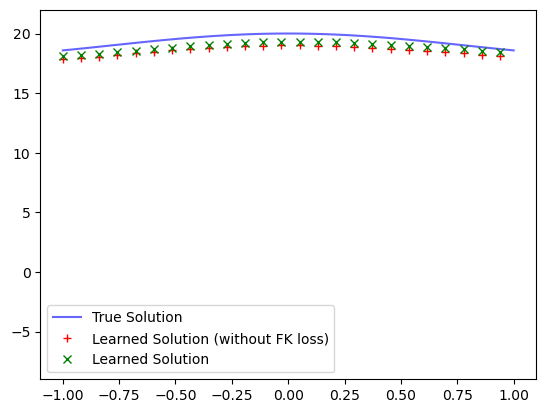

In [32]:
u.load_state_dict(torch.load("the_network_07.pt"))
x_test = torch.linspace(-1, 1, 100).unsqueeze(dim=1) * (torch.tensor([0.] * (D-1) + [1.]))
plt.plot(np.linspace(-L, L, 100), vmap(u_true)(x_test).detach().numpy(), "b", alpha=0.6)
plt.plot(np.linspace(-L, L, 100)[::4], u(x_test).squeeze().detach().numpy()[::4], "r+")

u.load_state_dict(torch.load("old_with_FKloss/the_network_07.pt"))
plt.plot(np.linspace(-L, L, 100)[::4], u(x_test).squeeze().detach().numpy()[::4], "gx")


plt.ylim(-9, 22)


plt.legend(["True Solution", "Learned Solution (without FK loss)", "Learned Solution", ])
plt.savefig("20d_axis.png") 
plt.show()